In [1]:
# Get target list; this follows the selection in ../document/figures/targets.py 
import sys
sys.path.append('..')

from peerless.catalogs import KICatalog, KOICatalog, EBCatalog, BlacklistCatalog
import numpy as np

stlr = KICatalog().df
m = (4200 <= stlr.teff) & (stlr.teff <= 6100)
m &= stlr.radius <= 1.15
m &= stlr.dataspan > 365.25*2.
m &= stlr.dutycycle > 0.6
m &= stlr.rrmscdpp07p5 <= 1000.
m &= stlr.kepmag < 15.

# known EBs
ebs = set(np.array(EBCatalog().df["#KIC"]))

# KOI false positives
kois = KOICatalog().df
kois = kois[kois.koi_disposition == "FALSE POSITIVE"]
fps = set(np.array(kois.kepid))

# And then finally the blacklist.
bl = set(np.array(BlacklistCatalog().df.kicid))

# The full list of ignores.
ignore = fps | bl #ebs | fps | bl  #Don't ignore EBs for purposes of prediction
m &= ~stlr.kepid.isin(ignore)

targets = stlr[m]

In [2]:
targets[['kepid','mass','feh']].count()

kepid    39626
mass     38983
feh      39626
dtype: int64

In [3]:
# funny, there seem to be some missing masses.  Let's artificially add those in, with M=R
bad = targets.mass.isnull()
targets.loc[bad, 'mass'] = targets.loc[bad, 'radius']

/u/tdm/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [30]:
targets.to_hdf('targets.h5','df')

/u/tdm/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:2577: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['tm_designation', 'prov_sec', 'datalink_dvr', 'st_delivname', 'st_vet_date_str', 'ra_str', 'dec_str', 'teff_prov', 'logg_prov', 'feh_prov']]

  warnings.warn(ws, PerformanceWarning)


In [31]:
targets = pd.read_hdf('targets.h5', 'df')

In [4]:
# Simulation a population of binary stars and observe them.

from sims import BinaryPopulation
ebs = BinaryPopulation(targets)
obscols = ['period','d_pri','d_sec','T14_pri','T14_sec',
             'b_pri','b_sec','k','n_pri','n_sec',
            'radius_A','radius_B','flux_ratio', 'dutycycle']
obs = ebs.observe(query='period > 5')[obscols]
len(obs)

/u/tdm/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


201

OK, this is how many EBs we predict there to be with periods greater than 5 days.  How does this compare with the actual EB catalog?

In [5]:
# Total number of Kepler EBs with P > 5, scaled by number of targets
from __future__ import division
len(EBCatalog().df.query('period>5')) * (len(targets)/len(KICatalog().df))

224.75436655536478

OK, this is creepy-close.  But this is very encouraging.  Means we should be able to take seriously the results of this simulation.  What does it say about single/double eclipses (either only primary or only secondary)?

In [6]:
dfm_query = '((n_pri + n_sec) < 3) and (n_pri==0 or n_sec==0)'
candidates = obs.query(dfm_query)
candidates

,period,d_pri,d_sec,T14_pri,T14_sec,b_pri,b_sec,k,n_pri,n_sec,radius_A,radius_B,flux_ratio,dutycycle
11065,2725.835950,0.000000,0.023798,0.000000,0.102429,20.877285,0.644034,0.327732,0,1,0.616,0.201883,0.024378,0.8751
40861,2309.481266,0.000000,0.107174,0.000000,0.236587,15.332992,0.564515,0.856833,0,1,0.898,0.769436,0.167153,0.8751
64747,1098.309004,0.081113,0.000000,0.252707,0.000000,1.228755,10.394288,0.658635,1,0,1.127,0.742282,0.109136,0.6989
66447,751.577729,0.000000,0.047757,0.000000,0.121635,10.318855,0.423898,0.466985,0,2,0.911,0.425423,0.050152,0.8751
86833,2041.557141,0.097466,0.046983,0.851577,0.851577,1.463392,1.463392,0.992367,1,0,0.773,0.767099,0.474118,0.8751
132029,1024.360507,0.227591,0.000000,0.115892,0.000000,0.994415,49.822940,0.987206,1,0,0.722,0.712763,0.721112,0.8752


Let's look at the depth vs. duration for these signals.

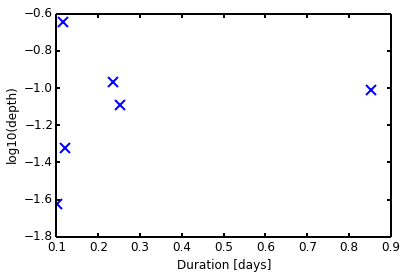

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

pri = candidates.n_pri > 0
sec = candidates.n_sec > 0

depth = pri*candidates.d_pri + sec*candidates.d_sec
duration = pri*candidates.T14_pri + sec*candidates.T14_sec

plt.plot(duration, np.log10(depth), 'x', ms=10);
plt.xlabel('Duration [days]')
plt.ylabel('log10(depth)')

OK, so that's for unblended EBs.  What about background EBs?  We can pretty fairly ignore hierarchical systems at these long periods, I think.

OK, for the BG population, we need to probabilistically populate each target star with background stars.  This background star probability can be taken from Morton & Johnson (2011).  

$$P_{BG} = C(m_{Kp}) + A(m_{Kp}) e^{-b/B(m_{Kp})}$$

where $A$, $B$, and $C$ are all polynomial functions of Kepler mag

In [8]:
pA = [-2.5038e-3, 0.12912, -2.4273, 19.980, -60.931]
pB = [3.0668e-3, -0.15902, 3.0365, -25.320, 82.605]
pC = [-1.5465e-5, 7.5396e-4, -1.2836e-2, 9.6434e-2, -0.27166]

def Pbg(Kp, b, r=4):
    """Expected number of BG stars within r", in magnitude range (Kp, Kp + 10)
    """
    if Kp < 11:
        Kp = 11
    if Kp > 16:
        Kp = 16
    return (r/2)**2*(np.polyval(pC, Kp) + 
                     np.polyval(pA, Kp)*np.exp(-b/np.polyval(pB, Kp)))

OK, so then let's create a new background "target" star population.  For each star in the target list, give it some BG stars.

In [9]:
from astropy.coordinates import SkyCoord
import pandas as pd
from scipy.stats import poisson
from astropy import constants as const

G = const.G.cgs.value
MSUN = const.M_sun.cgs.value
RSUN = const.R_sun.cgs.value

from vespa.stars.populations import BGStarPopulation_TRILEGAL

ra, dec = 290.665452, 44.484019 #Center of Kepler field
bgpop = BGStarPopulation_TRILEGAL('mod13_bg.h5',ra=ra, dec=dec)

def generate_bg_targets(bg):

    c = SkyCoord(targets.ra, targets.dec, unit='deg')
    bs = c.galactic.b.deg

    dataspan = []
    dutycycle = []
    mass_A = []
    radius_A = []
    age = []
    feh = []
    kepmag_target = []
    kepmag_A = []
    index = []
    for (ix, s), b in zip(targets.iterrows(), bs):
        n = poisson(Pbg(s.kepmag, b)).rvs()
        for i in range(n):
            bg_star = bg.stars.ix[np.random.randint(len(bg.stars))]
            Kp = s.kepmag
            while not ((bg_star.Kepler_mag > Kp) and 
                       (bg_star.Kepler_mag < Kp+10)):
                bg_star = bg.stars.ix[np.random.randint(len(bg.stars))]
            mass = bg_star.Mact
            radius = np.sqrt(G * mass * MSUN / 10**bg_star.logg)/RSUN
            dataspan.append(s.dataspan)
            dutycycle.append(s.dutycycle)
            mass_A.append(mass)
            radius_A.append(radius)
            kepmag_target.append(s.kepmag)
            kepmag_A.append(bg_star.Kepler_mag)
            age.append(bg_star.logAge)
            feh.append(bg_star['[M/H]'])
            index.append(ix)

    bg_targets = pd.DataFrame({'dataspan':dataspan,
                              'dutycycle':dutycycle,
                              'mass_A':mass_A,
                              'radius_A':radius_A,
                               'age':age,
                               'feh':feh,
                               'kepmag_target':kepmag_target,
                               'kepmag_A':kepmag_A}, index=index)
    return bg_targets

bg_targets = generate_bg_targets(bgpop)
bg_targets.to_hdf('bg_targets.h5', 'df')
bg_targets = pd.read_hdf('bg_targets.h5', 'df')

In [10]:
len(bg_targets)

22770

In [11]:
from sims import BG_BinaryPopulation
bgs = BG_BinaryPopulation(bg_targets)

In [12]:
bg_obs = bgs.observe(query='period > 5')
len(bg_obs)

58

In [13]:
bg_obs.query(dfm_query)[obscols]

,period,d_pri,d_sec,T14_pri,T14_sec,b_pri,b_sec,k,n_pri,n_sec,radius_A,radius_B,flux_ratio,dutycycle
91817,3715.869917,0.002701,0.000971,0.170548,0.762142,0.045578,0.204931,0.809441,1,0,0.560899,0.454014,0.261950,0.8753
133688,675.090038,0.000000,0.000087,0.000000,0.096168,2.748664,0.270954,1.000000,0,2,0.429373,0.429373,0.774936,0.8751
194508,2432.795168,0.000000,0.000011,0.000000,0.083732,22.703404,0.477178,0.454831,0,1,0.414388,0.188476,0.088722,0.8751


This is a smaller number than the EBs, for several reasons.  Fewer target stars and smaller radii (lower transit probability) explain it all.

In [21]:
ok = bgs.radius_B > 0
np.median(bgs.radius_A[ok] + bgs.radius_B[ok])

0.56807452903595945

In [22]:
ok = ebs.radius_B > 0
np.median(ebs.radius_A[ok] + ebs.radius_B[ok])

1.3747374721977597

In [23]:
len(targets)

39626

In [25]:
22770./39626 * (0.568/1.375) * 225

53.40857013072225

OK, now let's write scripts to generate lots of these observed single-transit catalogs, to get some averages.

In [27]:
from peerless.settings import PEERLESS_DATA_DIR

In [28]:
PEERLESS_DATA_DIR

'/u/tdm/peerless'

In [29]:
ls /u/tdm/peerless

catalogs/
